In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats
import random
import time
  

In [2]:

'''
This function generates ARTIFICIAL statistics (mean and std) for 'nb_pts' observations using one instrument
The purpose of this function is to 'simulate' what the validation does after SNN training
During validation, knowing ground truth, it is possible to estimate how far away predictions and reality are
Parameter 'k' should be smaller than 1 (usually 0.1 or less) since it indicates prediction error
'''
def generate_snn_stats(nb_pts, k):
    
    max_val = 1
    min_val = 0
    abs_max_err = (max_val-min_val)*k
    
    array_true = np.random.uniform(low=0.0, high=1.0, size=(nb_pts,))
    array_snn = np.zeros(nb_pts)
    
    for idx in range(len(array_true)):
        err = np.random.uniform(low=-abs_max_err, high=abs_max_err, size=(1,))
        array_snn[idx] = array_true[idx]*(1 + err)


    error = array_true-array_snn

    std = np.std(error)
    mean = np.mean(error)
    
    return mean, std


'''
This function estimates the envelope of three PDFs
The envelope is just used for visualization, it's not important for pose merging purposes
'''
def get_mixture(pdf_1, pdf_2, pdf_3):
    
    scaler = 0.33
    pdf_mixt = (pdf_1 + pdf_2 + pdf_3) * scaler
    
    return pdf_mixt

'''
The product of 3 gaussian PDFs is a gaussian PDF
This function estimates the mu and sigma of such gaussian
It also return the PDF for a given array of values

Inputs: 
 - values: array of float between 0 and 1 
 - mu: array of means (from N 'observations' using three instruments: cam 1, 2, 3)
 - sigma: array of stds (from N 'observations' using three instruments: cam 1, 2, 3)
 
 Outputs:
 - pdf_123: probability distribution obtained from three instruments 
 - mu_123: mean of pdf_123
 - sigma_123: std of pdf_123
 
'''
def get_product(values, mu, sigma):
    
    mu_1 = mu[0]
    mu_2 = mu[1]
    mu_3 = mu[2]
    
    ss_1 = sigma[0]**2
    ss_2 = sigma[1]**2
    ss_3 = sigma[2]**2
    
    
    mu_123 = (ss_1*ss_2*mu_3 + ss_2*ss_3*mu_1 + ss_3*ss_1*mu_2)/(ss_3*ss_2 + ss_2*ss_1 + ss_1*ss_3)
    sigma_123 = math.sqrt((ss_1 * ss_2 * ss_3)/(ss_1*ss_2 + ss_2*ss_3 + ss_3*ss_1))
    
    
    pdf_123 = stats.norm.pdf(values, mu_123, sigma_123)
    
    return pdf_123, mu_123, sigma_123

'''
This function estimates how likely it is that a certain (x,y,z) is the true one
mu and sigma are arrays containing mean and std for x,y,z coordinates
The purpose of this function is to faciltiate visualization (not needed for pose merging)
'''
def get_joint(x, y, z, mu, sigma):
    
    p_x = np.exp(-((x-mu[0])**2)/(2*sigma[0]**2))/(sigma[0]*math.sqrt(2*math.pi))
    p_y = np.exp(-((y-mu[1])**2)/(2*sigma[1]**2))/(sigma[1]*math.sqrt(2*math.pi))
    p_z = np.exp(-((z-mu[2])**2)/(2*sigma[2]**2))/(sigma[2]*math.sqrt(2*math.pi))
    
        
    return p_x*p_y*p_z


'''
This function produces 9x2 parameters:mean and std for all combinations of camera/axis (1,2,3 * x,y,z)
Some values are hardcoded in 'e_per' to account for uncertainty for each axis (which depends on camera pose)
'''
def produce_snn_stats(nb_pts):
    
    e_per = np.array([[0.04, 0.08, 0.18], [0.05, 0.10, 0.19], [0.03, 0.09, 0.21]])
    e_per = np.array([[0.001, 0.001, 0.001], [0.001, 0.001, 0.001], [0.001, 0.001, 0.001]])
    print(e_per)
    
    cam_pdf_params = np.zeros((3,3,2)) # {1,2,3} | {x,y,z} | {mean, std}

    #Cam 1
    cam_pdf_params[0,0,:] = generate_snn_stats(nb_pts, e_per[0,0]) # x
    cam_pdf_params[0,1,:] = generate_snn_stats(nb_pts, e_per[0,1]) # y
    cam_pdf_params[0,2,:] = generate_snn_stats(nb_pts, e_per[0,2]) # z

    #Cam 2
    cam_pdf_params[1,0,:] = generate_snn_stats(nb_pts, e_per[1,0]) # x
    cam_pdf_params[1,1,:] = generate_snn_stats(nb_pts, e_per[1,1]) # y
    cam_pdf_params[1,2,:] = generate_snn_stats(nb_pts, e_per[1,2]) # z

    #Cam 3
    cam_pdf_params[2,0,:] = generate_snn_stats(nb_pts, e_per[2,0]) # x
    cam_pdf_params[2,1,:] = generate_snn_stats(nb_pts, e_per[2,1]) # y
    cam_pdf_params[2,2,:] = generate_snn_stats(nb_pts, e_per[2,2]) # z
    
    return cam_pdf_params

'''
Given a set of PDFs (for cams 1,2,3) and their product, this function's purpose is mainly visualization
'''
def plot_cam_all_xyz_pdf(xyz, pdf):    
    
    # Plotting Everything
    fig, axs = plt.subplots(3,1, figsize=(12,16))
    fig.tight_layout(pad=5.0)

    horizontal_axes = ['x', 'y', 'z']
    labels = ['Cam 1', 'Cam 2', 'Cam3', 'Prod', 'Mixt.']
    styles = ['-', '-', '-', '--', '-.']
    for j in range(3): # x, y, z
        for k in range(3+2): # 1,2,3, product, mixture

            axs[j].plot(xyz[j,:], pdf[k,j,:], label=labels[k], linestyle = styles[k])
            axs[j].set_xlabel(horizontal_axes[j])
            axs[j].set_ylabel('Density of Probability')
            axs[j].legend(bbox_to_anchor=(1.2, 0.65))
            axs[j].set_xlim([min(xyz[j,:]), max(xyz[j,:])])


    
'''
This function produces 3 PDFs from SNN stats and one from the product of these
The function plots the PDFs (in 3 subplots, one per axis) and returns two arrays: mu and sigma
'''
def generate_pdfs(nb_pts):

    cam_pdf_params = produce_snn_stats(nb_pts)
    
    base_xyz = np.linspace(stats.norm.ppf(0.45), stats.norm.ppf(0.55), nb_pts)

    pdf_center = np.zeros(3)
    xyz = np.zeros((3,nb_pts))
    pdf = np.zeros((5,3,nb_pts))
    mu = np.zeros((3,5))
    sigma = np.zeros((3,5))
    snn_values = np.zeros((3,3)) # Represents the output of the SNN: cams 1, 2, 3 --> (x, y, z)  


    # Generating PDFs (+ prodcuts and mixtures)
    for j in range(3): # x, y, z

        # Ground truth (for x, y, z according to current 'j') is independent of the camera
        pdf_center[j] = np.random.uniform(low=0.0, high=0.9, size=(1,)) 

        # This is done to re-center xyz array (for visual purposes)
        xyz[j,:] = base_xyz + pdf_center[j] 

        # Checking output of each camera
        for i in range(3): # Cam 1, 2, 3

            # @TODO: high=0.00001 ... 0.1!
            
            # Each camera behaves its own way: some error, vs ground truth, is expected in the 'snn_values' (<10%)
            snn_values[i,j] = pdf_center[j] + np.random.uniform(low=0.0, high=0.01, size=(1,))

            # The Gaussians, from the SNN stats, are centered around the 'snn_values'
            mu[j,i] = snn_values[i,j] + cam_pdf_params[i,j,0]
            sigma[j,i] = cam_pdf_params[i,j,1]

            # PDF is calculated, using stats, with the purpose of visualization (not needed for pose merging)
            pdf[i,j,:] = stats.norm.pdf(xyz[j,:], mu[j,i], sigma[j,i]) 

        # Once PDFs for cameras 1,2,3 are estimated, their product is obtained. IMPORTANT: mu[j,3] and sigma[j,3] 
        pdf[3,j,:], mu[j,3], sigma[j,3] = get_product(xyz[j,:], mu[j,:], sigma[j,:]) 

        # The envelope of the PDFs for cameras 1,2,3 is also estimated (for visualization)
        pdf[4,j,:] = get_mixture(pdf[0,j,:], pdf[1,j,:], pdf[2,j,:])

    plot_cam_all_xyz_pdf(xyz, pdf)
    
    print("The object is likely to be located at (%3.3f, %3.3f, %3.3f)" %(mu[0,3], mu[1,3], mu[2,3]))

    return mu, sigma

'''
This function reconstructs a 3D representation of the probabilities of the actual (x,y,z) being somewhere in space
'''
def visualize_3d(nb_pts, mu, sigma):
    
    x = y = z = np.linspace(stats.norm.ppf(0.40), stats.norm.ppf(0.60), nb_pts) + np.mean(mu[:,3])

    # Getting joint probabilities
    start = time.time()
    p = np.zeros((nb_pts,nb_pts, nb_pts))
    for idx_x in range (nb_pts): # x, y, z
        for idx_y in range (nb_pts): # x, y, z
            for idx_z in range (nb_pts): # x, y, z   
                p[idx_x, idx_y, idx_z] = get_joint(x[idx_x], y[idx_y], z[idx_z], mu[:,3], sigma[:,3])

    stop = time.time()
    elapsed = stop - start
    print("Joint probabilities obtained after: " + str(int(elapsed)) + " seconds.")

    # Creating figure
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection="3d")

    idx = p > 0.5

    # Creating plot
    xx, yy, zz = np.meshgrid(x, y, z)
    ax.scatter3D(xx[idx], yy[idx], zz[idx], c=p[idx], cmap='viridis', vmin=0, vmax=10, marker='.')
    # ax.plot_surface(xx[idx], yy[idx], zz[idx], facecolors=p[idx], cmap='viridis', vmin=0, vmax=10, marker='.')

    xs = np.linspace(0, 1, nb_pts)
    ys = np.linspace(0, 1, nb_pts)
    zs = np.linspace(0, 1, nb_pts)

    X, Y = np.meshgrid(xs, ys)
    Z = np.ones((nb_pts,nb_pts))*mu[2,3]
    ax.plot_surface(Y, X, Z, alpha=0.2, color='k')

    Y, Z = np.meshgrid(ys, zs)
    X = np.ones((nb_pts,nb_pts))*mu[0,3]
    ax.plot_surface(Y, X, Z, alpha=0.2, color='k')

    X, Z = np.meshgrid(xs, zs)
    Y = np.ones((nb_pts,nb_pts))*mu[1,3]
    ax.plot_surface(Y, X, Z, alpha=0.2, color='k')

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    ax.set_zlabel('z')
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_yticks(np.linspace(0, 1, 11))
    ax.set_zticks(np.linspace(0, 1, 11))

    plt.show()  
    
    

[[0.001 0.001 0.001]
 [0.001 0.001 0.001]
 [0.001 0.001 0.001]]
The object is likely to be located at (0.527, 0.571, 0.340)


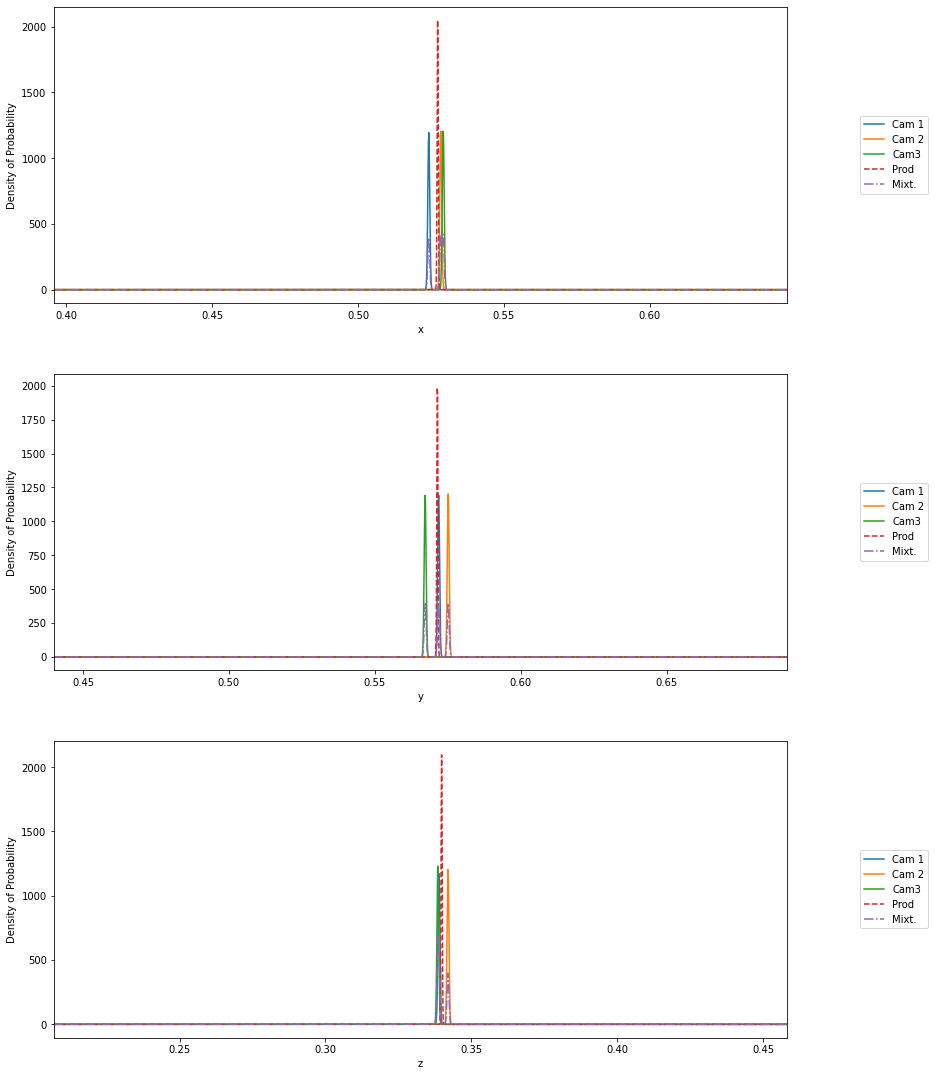

In [3]:


nb_pts = 2000

%matplotlib inline
mu, sigma = generate_pdfs(nb_pts)


In [4]:

# %matplotlib notebook
# visualize_3d(nb_pts, mu, sigma)


In [5]:
# CURVE FIT TO GAUSSIAN: https://stackoverflow.com/questions/19206332/gaussian-fit-for-python/19207683